In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('kidney_disease.csv')
# Misclassified data
data[['pcv', 'wc', 'rc']] = data[['pcv', 'wc', 'rc']].apply(pd.to_numeric, errors='coerce')
data_cleaned = data
numeric_columns = ['age', 'bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
non_numeric_columns = ['sg', 'al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane'] 

data.replace('ckd\t', 'ckd', inplace = True)
data.replace(' yes', 'yes', inplace = True)
data.replace('\tno', 'no', inplace = True)
data.replace('\tyes', 'yes', inplace = True)

for column in non_numeric_columns:
    data[column] = data[column].fillna(data[column].mode()[0])

data = data.drop(['id'], axis = 1)
print(data.isnull().sum())

age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64


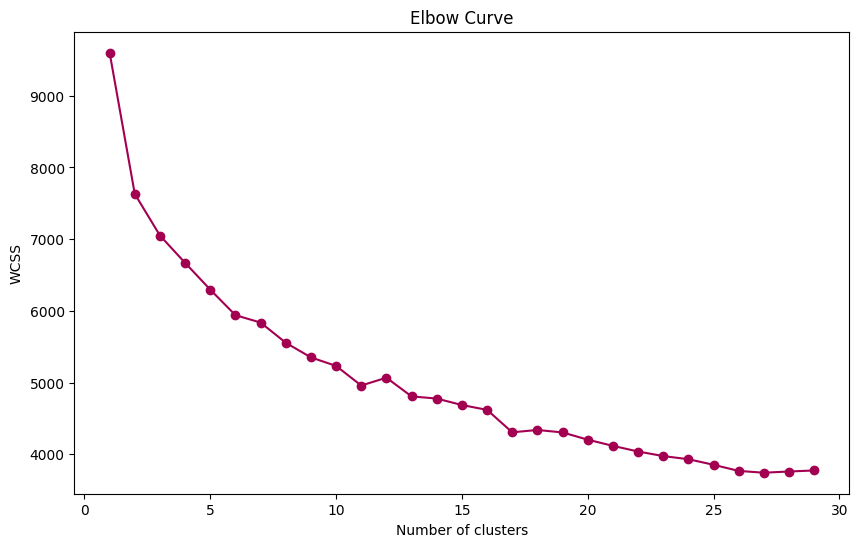

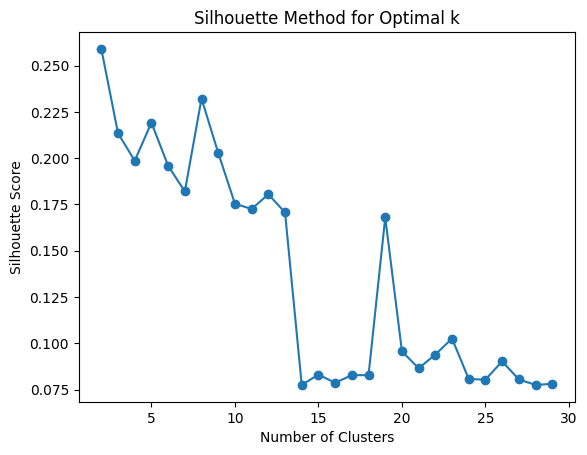

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Accuracy: 0.9916666666666667
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



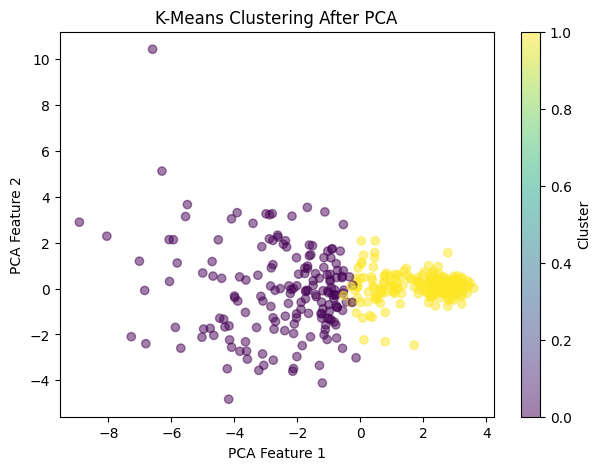

Confusion Matrix:
[[44  1]
 [ 0 75]]


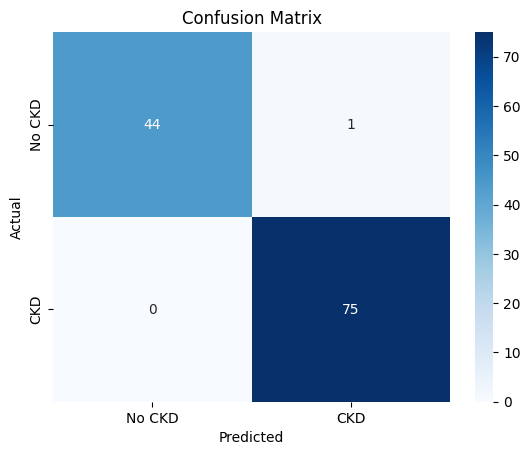

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Encode categorical variables
label_encoders = {}
non_numeric_columns = ['sg', 'al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane'] 
for col in non_numeric_columns:
# for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  

# Separate features and target variable
target_col = 'classification'
X = data.drop(columns=[target_col])  
y = data[target_col]
y = y.map({'ckd': 1, 'notckd': 0})

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (Retain 95% Variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Determine optimal clusters
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='random', random_state=42, n_init=10)
    kmeans.fit(X_scaled)  # Use original features, not PCA
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 30), wcss, marker='o', color='#a30052')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Curve')
plt.show()

# Use silhouette score to find best k
sil_scores = []
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, cluster_labels))

plt.plot(range(2, 30), sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

# Fit K-Means with optimal k
optimal_k = np.argmax(sil_scores) + 2  # Best k from silhouette scores
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels as feature
X_final = np.column_stack((X_scaled, clusters))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42, stratify=y)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate Model
print("Best Parameters:", grid_search.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize Clusters
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('K-Means Clustering After PCA')
plt.colorbar(label="Cluster")
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CKD', 'CKD'], yticklabels=['No CKD', 'CKD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
